In [1]:
import sys
# enable importing the modules from probcalkge
sys.path.append('../')
sys.path.append('../probcalkge')

In [2]:
from pprint import pprint
from copy import deepcopy
from typing import Iterable, Callable, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit

In [3]:
from probcalkge import Experiment, ExperimentResult
from probcalkge import get_calibrators
from probcalkge import get_datasets,  get_kgemodels
from probcalkge import brier_score, negative_log_loss, ks_error, ece, cal_curve

In [4]:
from probcalkge.calmodels2 import get_calibrators
ds = get_datasets()
cals = get_calibrators()
kges = get_kgemodels()

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


In [5]:
exp = Experiment(
    cals=[cals.uncal, cals.platt, cals.isot, cals.beta, cals.histbin, cals.temperature], 
    datasets=[ds.fb13, ds.wn18, ds.yago39, ds.dp50, ds.kinship, ds.umls], 
    kges=[kges.transE, kges.complEx, kges.distMult, kges.hoLE], 
    metrics=[brier_score, negative_log_loss, ks_error, ece]
    )

In [6]:
exp.load_trained_kges('../saved_models/')

Loaded models:
{'DBpedia50': {'ComplEx': <ampligraph.latent_features.models.ComplEx.ComplEx object at 0x000001C33144AE88>,
               'DistMult': <ampligraph.latent_features.models.DistMult.DistMult object at 0x000001C33ECE7C88>,
               'HolE': <ampligraph.latent_features.models.HolE.HolE object at 0x000001C33ECE7808>,
               'TransE': <ampligraph.latent_features.models.TransE.TransE object at 0x000001C348A87048>},
 'DBpedia_ET': OrderedDict([('ComplEx',
                             <ampligraph.latent_features.models.ComplEx.ComplEx object at 0x000001C33EE98048>),
                            ('DistMult',
                             <ampligraph.latent_features.models.DistMult.DistMult object at 0x000001C33EDE6EC8>),
                            ('TransE',
                             <ampligraph.latent_features.models.TransE.TransE object at 0x000001C3445C4048>)]),
 'FB13k': {'ComplEx': <ampligraph.latent_features.models.ComplEx.ComplEx object at 0x000001C33EA09F08>,

In [7]:
exp_res = exp.run_with_trained_kges()

training various calibrators for TransE on FB13k ...
training various calibrators for ComplEx on FB13k ...
training various calibrators for DistMult on FB13k ...
training various calibrators for HolE on FB13k ...
training various calibrators for TransE on WN11 ...
training various calibrators for ComplEx on WN11 ...
training various calibrators for DistMult on WN11 ...
training various calibrators for HolE on WN11 ...
training various calibrators for TransE on YAGO39 ...
training various calibrators for ComplEx on YAGO39 ...
training various calibrators for DistMult on YAGO39 ...
training various calibrators for HolE on YAGO39 ...
training various calibrators for TransE on DBpedia50 ...
training various calibrators for ComplEx on DBpedia50 ...
training various calibrators for DistMult on DBpedia50 ...
training various calibrators for HolE on DBpedia50 ...
training various calibrators for TransE on Kinship ...
training various calibrators for ComplEx on Kinship ...
training various cali

In [12]:
from sklearn.calibration import CalibrationDisplay

plt.rcParams['figure.dpi'] = 200 # default for me was 75
plt.rc('axes', labelsize=3)
plt.rc('axes', titlesize=3)
plt.rc('xtick', labelsize=3)
plt.rc('ytick', labelsize=3)
plt.rc('legend', fontsize=3)
plt.rc('lines', linewidth=0.5)
plt.rc('lines', markersize=0.5)


def plot_ds_kge_cals(data, kge, cals, ax=None):
    ax = plt.axes() if ax == None else ax

    for cal in cals:
        scores = kge.predict(data.X_test)
        probs = cal.predict(expit(scores))
        CalibrationDisplay.from_predictions(data.y_test, probs, ax=ax, name=cal.name)
    
    ax.set_title(f'{data.name}-{kge.name}')
    ax.legend()
    ax.get_legend().remove()
    ax.set(xlabel=None)
    ax.set(ylabel=None)
        

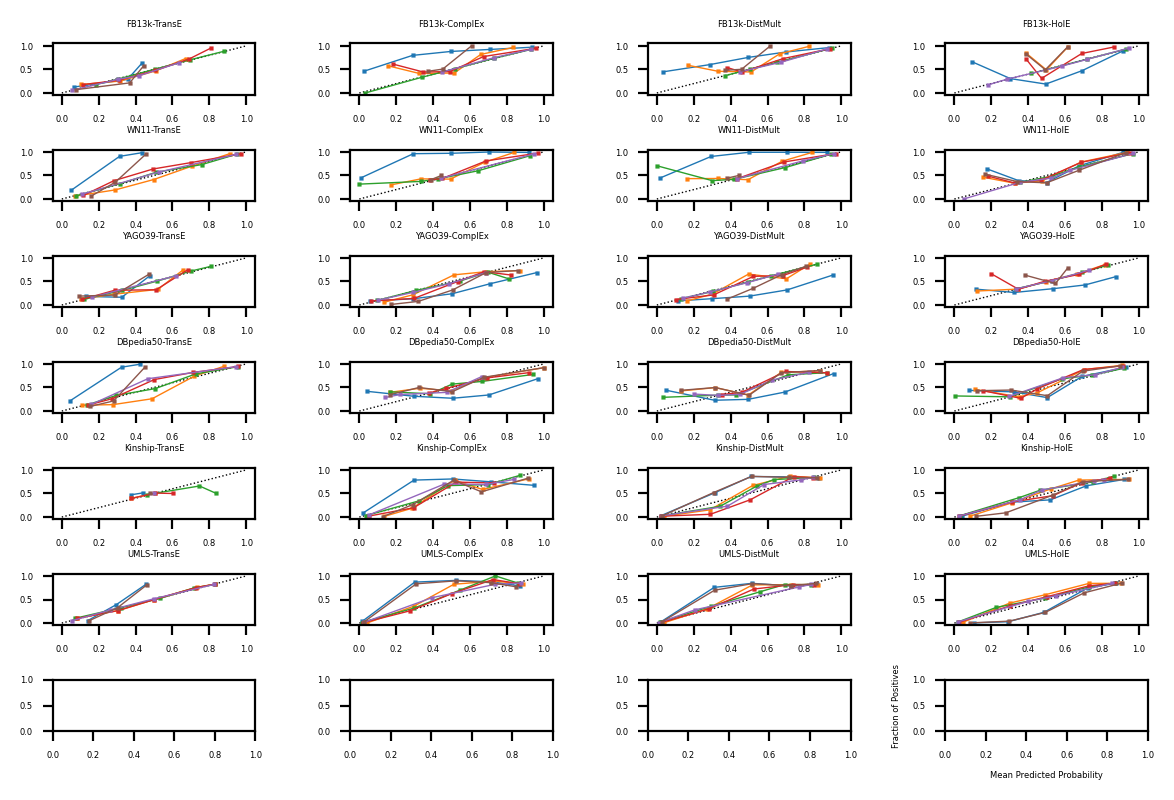

In [13]:
fig, axes = plt.subplots(7, 4)
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
fig.tight_layout(h_pad=0.8)
for i, data in enumerate(exp.datasets):
    for j, kge in enumerate(exp.trained_kges[data.name].values()):
        cals = exp.trained_cals[data.name][kge.name].values()
        plot_ds_kge_cals(data, kge, cals, axes[i][j])

# plt.legend()

In [10]:
from sklearn.metrics import accuracy_score

res = {}
for i, data in enumerate(exp.datasets):
    res[data.name] = {}
    for j, kge in enumerate(exp.trained_kges[data.name].values()):
        res[data.name][kge.name] = []
        for cal in  exp.trained_cals[data.name][kge.name].values():
            scores = kge.predict(data.X_test)
            probs = cal.predict(expit(scores))
            preds = probs > 0.5
            # print(f'{data.name}-{kge.name}-{cal.name}   {accuracy_score(data.y_test, preds)}')
            res[data.name][kge.name].append(accuracy_score(data.y_test, preds))


FB13k
WN11
YAGO39
DBpedia50
Kinship
UMLS


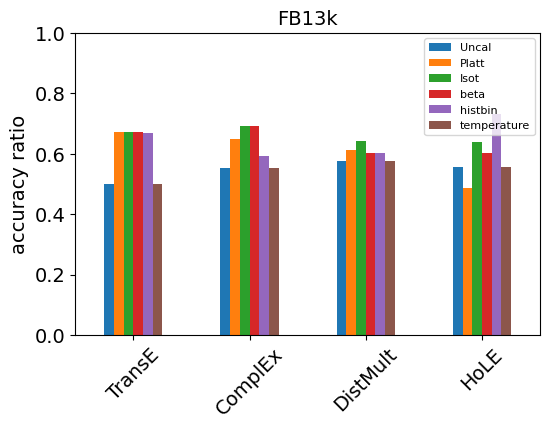

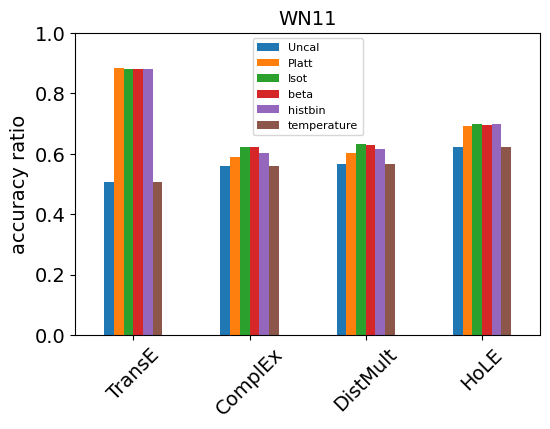

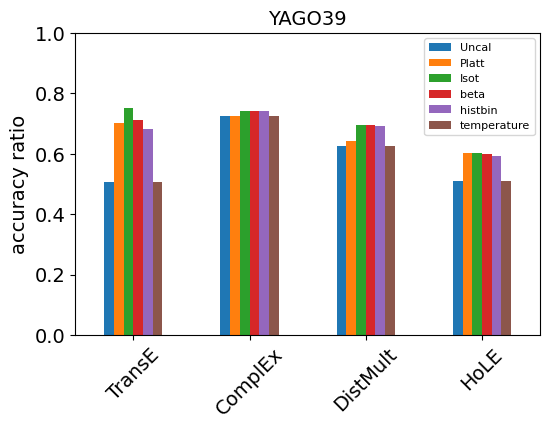

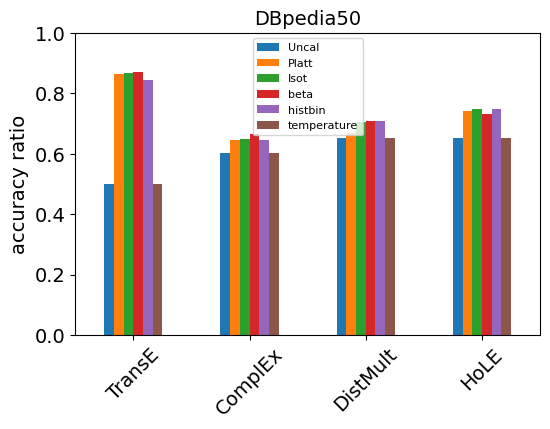

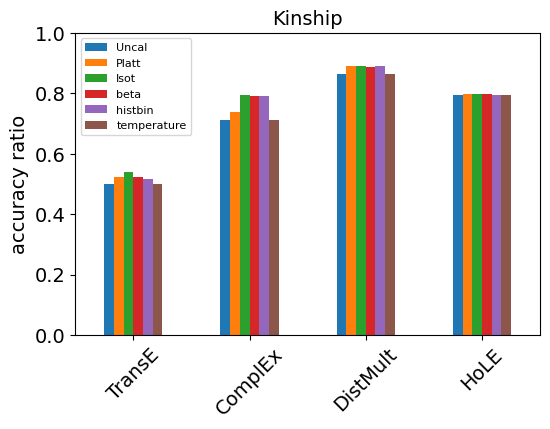

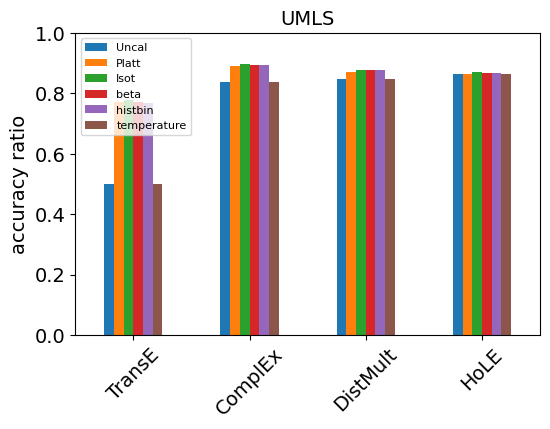

In [38]:
plt.rc('figure', dpi=100) # default for me was 75
plt.rc('axes', labelsize=14)
plt.rc('axes', titlesize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=8)
plt.rc('lines', linewidth=2)
plt.rc('lines', markersize=2)

for k in res.keys():
    print(k)
    # print(pd.DataFrame(res[k], index=['Uncal', 'Platt', 'Isot', 'beta', 'histbin', 'temperature']).T.round(3))
    ax = pd.DataFrame(res[k], index=['Uncal', 'Platt', 'Isot', 'beta', 'histbin', 'temperature']).T.round(3).plot(kind='bar')
    # ax.set_xlabel('KGE models ')
    ax.set_xticklabels(['TransE', 'ComplEx', 'DistMult', 'HoLE'], rotation = 45)
    ax.set_ylabel('accuracy ratio')
    ax.set_title(f'{k}')
    ax.set_ylim(0, 1.0)

In [ ]:
data = exp.datasets[0]
kge = exp.trained_kges[data.name]['TransE']
uncal = exp.trained_cals[data.name][kge.name]['UncalCalibrator']
scores = kge.predict(data.X_test)
probs = uncal.predict(expit(scores))
print(probs[:100])

[0.40978882 0.3134635  0.44023272 0.3631248  0.42911097 0.4267985
 0.38235217 0.37995046 0.4650749  0.35877123 0.45021406 0.42427185
 0.4316722  0.4338799  0.40771583 0.41017577 0.30693024 0.30416086
 0.43741935 0.4227099  0.45058128 0.04247923 0.41679534 0.32579112
 0.40685374 0.39295667 0.382622   0.38386127 0.3868234  0.36746413
 0.3961725  0.39801624 0.41509637 0.4142066  0.45218414 0.30735195
 0.45803636 0.45658156 0.46072307 0.45398152 0.40747622 0.43944788
 0.37178588 0.2957952  0.43806022 0.33853108 0.42448714 0.40702462
 0.38567284 0.38384676 0.4225623  0.37691087 0.4259166  0.37438318
 0.436951   0.4237531  0.4690824  0.41367948 0.46674827 0.04404256
 0.44479162 0.4082745  0.4162786  0.4177224  0.4170282  0.41459182
 0.44536072 0.40250546 0.447596   0.36946723 0.4481766  0.35705882
 0.4238242  0.41914722 0.36898947 0.3655842  0.4778787  0.3758284
 0.42504117 0.42381236 0.4630504  0.3785432  0.44573322 0.35444534
 0.41507396 0.4363318  0.44150132 0.42494556 0.41384995 0.433719

In [ ]:
platt = deepcopy(get_calibrators().platt)
platt.fit(uncal.predict(kge.predict(data.X_valid)), data.y_valid)
# accuracy_score(data.y_test, platt.predict(probs)>0.5)
accuracy_score(data.y_test, exp.trained_cals[data.name][kge.name]['PlattCalibrator'].predict(uncal.predict(expit(scores)))>0.5)

0.6718354963762009

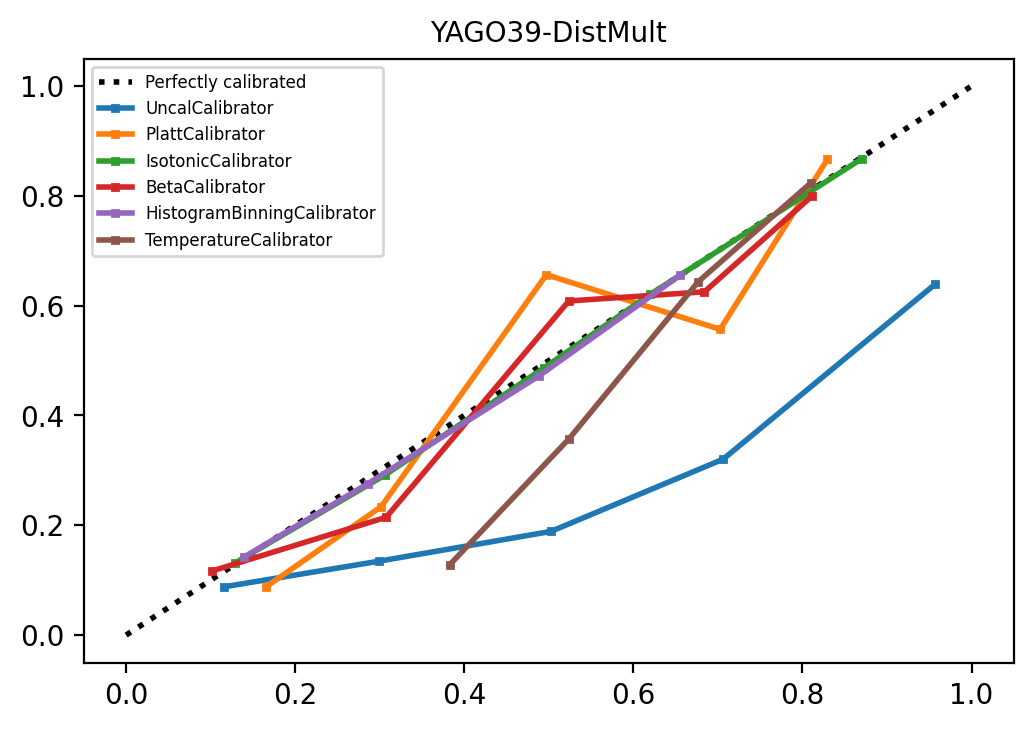

In [15]:
plt.rcParams['figure.dpi'] = 200 # default for me was 75
plt.rc('axes', labelsize=10)
plt.rc('axes', titlesize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=6)
plt.rc('lines', linewidth=2)
plt.rc('lines', markersize=2)

data = exp.datasets[2]
kge = exp.trained_kges[data.name]['DistMult']
c = exp.trained_cals[data.name][kge.name].values()
plot_ds_kge_cals(data, kge, c)
plt.legend()

In [40]:
from sklearn.metrics import accuracy_score
def per_rel_threshold(model, data):
    scores = model.predict(data.X_test)
    val_scores = model.predict(data.X_valid)
    thresholds = {r: np.median(np.sort(val_scores[data.X_valid[:, 1] == r])) for r in np.unique(data.X_valid[:, 1])}
    thresholds_test = np.vectorize(thresholds.get)(data.X_test[:, 1])
    per_relation_acc = accuracy_score(data.y_test, scores > thresholds_test)
    return per_relation_acc, thresholds

for data in exp.datasets:
    for kge in exp.trained_kges[data.name].values():
        try:
            print(f'{data.name} {kge.name}', per_rel_threshold(kge, data)[0])
        except TypeError as err:
            print(err)

FB13k TransE 0.6717933591774818
FB13k ComplEx 0.6643350750042137
FB13k DistMult 0.6248525198044834
FB13k HolE 0.5140948929715152
WN11 TransE 0.8818633918603471
WN11 ComplEx 0.5971277783416219
WN11 DistMult 0.5988531411752765
WN11 HolE 0.657921445245103


f:\TREAT\kgcal\.venv\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


YAGO39 TransE 0.781163883935808


f:\TREAT\kgcal\.venv\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


YAGO39 ComplEx 0.7167558221213595


f:\TREAT\kgcal\.venv\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


YAGO39 DistMult 0.6541308694007673


f:\TREAT\kgcal\.venv\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


YAGO39 HolE 0.5939374290808883
'>' not supported between instances of 'float' and 'NoneType'
'>' not supported between instances of 'float' and 'NoneType'
'>' not supported between instances of 'float' and 'NoneType'
'>' not supported between instances of 'float' and 'NoneType'
Kinship TransE 0.5260707635009311


f:\TREAT\kgcal\.venv\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
f:\TREAT\kgcal\.venv\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
f:\TREAT\kgcal\.venv\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


Kinship ComplEx 0.6927374301675978
Kinship DistMult 0.8300744878957169


f:\TREAT\kgcal\.venv\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
f:\TREAT\kgcal\.venv\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


Kinship HolE 0.7700186219739292
UMLS TransE 0.7708018154311649


f:\TREAT\kgcal\.venv\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
f:\TREAT\kgcal\.venv\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


UMLS ComplEx 0.8366111951588502
UMLS DistMult 0.8237518910741302
UMLS HolE 0.8494704992435703


f:\TREAT\kgcal\.venv\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
